In [1]:
# import the required libraries
import time  
import pyspark  
from pyspark.sql import SparkSession  
spark = spark = SparkSession.builder.appName("recommendation") \
    .config("spark.driver.memory", "24g") \
    .config("spark.executor.memory", "38g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/21 09:09:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# load the datasets using pyspark
movies = spark.read.load("../data/raw/movies.csv", format='csv', header = True)
ratings = spark.read.load('../data/raw/ratings.csv', format='csv', header = True)
links = spark.read.load("../data/raw/links.csv", format='csv', header = True)
tags = spark.read.load("../data/raw/tags.csv", format='csv', header = True)
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
|     1|     34|   2.0|943228491|
|     1|     36|   1.0|944249008|
|     1|     80|   5.0|944248943|
|     1|    110|   3.0|943231119|
|     1|    111|   5.0|944249008|
|     1|    161|   1.0|943231162|
|     1|    166|   5.0|943228442|
|     1|    176|   4.0|944079496|
|     1|    223|   3.0|944082810|
|     1|    232|   5.0|943228442|
|     1|    260|   5.0|943228696|
|     1|    302|   4.0|944253272|
|     1|    306|   5.0|944248888|
|     1|    307|   5.0|944253207|
|     1|    322|   4.0|944053801|
+------+-------+------+---------+
only showing top 20 rows


In [3]:
ratings = ratings.select("userId", "movieId", "rating")
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



In [4]:
# convert the data type to integer and float
df = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



In [5]:
# split the data into train, validation and test sets
train, validation, test = df.randomSplit([0.6,0.2,0.2], seed = 0)
print("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 19195595, 6403105, 6401504


In [6]:
from pyspark.sql.functions import col, sqrt
def RMSE(predictions):
    squared_diff = predictions.withColumn("squared_diff", pow(col("rating") - col("prediction"), 2))
    mse = squared_diff.selectExpr("mean(squared_diff) as mse").first().mse
    return mse ** 0.5

In [7]:
# implement the model using ALS algorithm and find the right hyperparameters using Grid Search
from pyspark.ml.recommendation import ALS

def GridSearch(train, valid, num_iterations, reg_param, n_factors):
    min_rmse = float('inf')
    best_n = -1
    best_reg = 0
    best_model = None
    # run Grid Search for all the parameter defined in the range in a loop
    for n in n_factors:
        for reg in reg_param:
            als = ALS(rank = n, 
                      maxIter = num_iterations, 
                      seed = 0, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop")            
            model = als.fit(train)
            predictions = model.transform(valid)
            rmse = RMSE(predictions)     
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(n, reg, rmse))
            # track the best model using RMSE
            if rmse < min_rmse:
                min_rmse = rmse
                best_n = n
                best_reg = reg
                best_model = model
                
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    # best model and its metrics
    print('\nThe best model has {} latent factors and regularization = {}:'.format(best_n, best_reg))
    print('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    return best_model

In [8]:
# build the model using different ranges for Grid Search
from pyspark.sql.functions import col, sqrt
num_iterations = 10
# ranks = [6, 8, 10, 12]
# reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]
ranks = [12]
reg_params = [0.05]

start_time = time.time()
final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)
print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

12 latent factors and regularization = 0.05: validation RMSE is 0.7896918639834328



The best model has 12 latent factors and regularization = 0.05:
traning RMSE is 0.7099878658149557; validation RMSE is 0.7896918639834328
Total Runtime: 64.30 seconds


In [11]:
# test the accuracy of the model on test set using RMSE 
pred_test = final_model.transform(test)
print('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.7896519280173803


In [12]:
# test for a single user 
single_user = test.filter(test['userId']==12).select(['movieId','userId'])
single_user.show()

+-------+------+
|movieId|userId|
+-------+------+
|     31|    12|
|    724|    12|
|   1022|    12|
|   1704|    12|
|   2858|    12|
|   5620|    12|
+-------+------+



In [13]:
# fetch the names of the movies 
single_user.join(movies, single_user.movieId == movies.movieId, 'inner').show()

+-------+------+-------+--------------------+--------------------+
|movieId|userId|movieId|               title|              genres|
+-------+------+-------+--------------------+--------------------+
|     31|    12|     31|Dangerous Minds (...|               Drama|
|    724|    12|    724|   Craft, The (1996)|Drama|Fantasy|Hor...|
|   1022|    12|   1022|   Cinderella (1950)|Animation|Childre...|
|   1704|    12|   1704|Good Will Hunting...|       Drama|Romance|
|   2858|    12|   2858|American Beauty (...|       Drama|Romance|
|   5620|    12|   5620|Sweet Home Alabam...|      Comedy|Romance|
+-------+------+-------+--------------------+--------------------+



In [14]:
# verify the prediction rating for the user
reccomendations = final_model.transform(single_user)
reccomendations.orderBy('prediction',ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   5620|    12| 3.6705217|
|     31|    12| 3.4757984|
|   1022|    12|   3.20873|
|    724|    12| 3.0409725|
|   1704|    12| 3.0052028|
|   2858|    12| 2.5917907|
+-------+------+----------+



In [15]:
# fetch the names of the movies
reccomendations.join(movies, reccomendations.movieId == movies.movieId, 'inner').show()

+-------+------+----------+-------+--------------------+--------------------+
|movieId|userId|prediction|movieId|               title|              genres|
+-------+------+----------+-------+--------------------+--------------------+
|     31|    12| 3.4757984|     31|Dangerous Minds (...|               Drama|
|    724|    12| 3.0409725|    724|   Craft, The (1996)|Drama|Fantasy|Hor...|
|   1022|    12|   3.20873|   1022|   Cinderella (1950)|Animation|Childre...|
|   1704|    12| 3.0052028|   1704|Good Will Hunting...|       Drama|Romance|
|   2858|    12| 2.5917907|   2858|American Beauty (...|       Drama|Romance|
|   5620|    12| 3.6705217|   5620|Sweet Home Alabam...|      Comedy|Romance|
+-------+------+----------+-------+--------------------+--------------------+



In [16]:
from pyspark.sql.functions import col, lit

# select a single user from the test set
user_id = 12
single_user_ratings = test.filter(test['userId'] == user_id).select(['movieId', 'userId', 'rating'])

# display the movies the user has liked
print("Movies liked by user with ID", user_id)
single_user_ratings.join(movies, 'movieId').select('movieId', 'title', 'rating').show()

# generate recommendations for the user
all_movies = df.select('movieId').distinct()
user_movies = single_user_ratings.select('movieId').distinct()
movies_to_recommend = all_movies.subtract(user_movies)

# predict ratings for movies the user has not rated yet
recommendations = final_model.transform(movies_to_recommend.withColumn('userId', lit(user_id)))

# filter out the movies that the user has already rated or seen (this filters out the movies that the user has not liked as well)
recommendations = recommendations.filter(col('prediction') > 0)

# display the recommendations with movie names
print("Recommended movies for user with ID", user_id)
recommended_movies = recommendations.join(movies, 'movieId').select('movieId', 'title', 'prediction')

# Sort recommended movies by prediction in descending order
ordered_recommendations = recommended_movies.orderBy(col('prediction').desc())

# Display the ordered recommendations
ordered_recommendations.show()

Movies liked by user with ID 12


+-------+--------------------+------+
|movieId|               title|rating|
+-------+--------------------+------+
|     31|Dangerous Minds (...|   3.0|
|    724|   Craft, The (1996)|   4.5|
|   1022|   Cinderella (1950)|   3.0|
|   1704|Good Will Hunting...|   3.0|
|   2858|American Beauty (...|   5.0|
|   5620|Sweet Home Alabam...|   4.5|
+-------+--------------------+------+

Recommended movies for user with ID 12


+-------+--------------------+----------+
|movieId|               title|prediction|
+-------+--------------------+----------+
| 200252|The Ethereal Mela...|  6.792939|
| 281144|Fantasy Football ...|  5.942049|
| 154921|Future My Love (2...| 5.9267683|
| 185337|Hans Zimmer: Live...| 5.9035535|
| 163783|  Summer of 8 (2016)|  5.875811|
|  94101|Crime After Crime...| 5.8409166|
| 128872|  Love is God (2003)|  5.832617|
| 110138|Aya of Yop City (...|  5.796935|
| 282387|Beyond the Univer...| 5.6659055|
| 149709|Barking at the St...| 5.6479445|
| 265582|The Whole Truth (...|  5.646632|
| 126941|Joni's Promise (2...| 5.6273894|
| 245740|   The Tangle (2021)| 5.6070194|
|  70661|Tyler Perry's Mee...| 5.5952744|
| 138684|         Waar (2013)|  5.594674|
| 162660|God's Not Dead 2 ...| 5.5944133|
| 158338|Tig Notaro: Boyis...| 5.5798864|
| 158518|Under the Gun (2016)| 5.5354614|
| 283549|Johan Falk: Blods...|  5.535195|
| 283553|Johan Falk: Slute...|  5.535195|
+-------+--------------------+----

### Metric for ALS

In [33]:
# 7. Pour chaque user du test, trouver ses 5 voisins les plus proches
test_users = test.select("userId").distinct().toPandas()["userId"].values

In [36]:
precision_list, recall_list = [], []
k = 25

# Supposons que test_users est la liste de userId à tester
for user in test_users[:100]:
    # Films déjà vus dans le train
    seen_train = train.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    # Films réellement vus dans le test
    seen_test = test.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    if len(seen_test) == 0:
        continue

    # Recommandations ALS pour ce user (predict top k)
    user_df = spark.createDataFrame([[int(user)]], ["userId"])
    recos = final_model.recommendForUserSubset(user_df, k)
    reco_movies = recos.selectExpr("explode(recommendations) as rec") \
                       .select("rec.movieId") \
                       .rdd.flatMap(lambda x: x).collect()
    # (Optionnel: retirer les films déjà vus dans le train si tu veux)
    reco_movies = [m for m in reco_movies if m not in seen_train]

    hits = set(reco_movies) & set(seen_test)
    precision = len(hits) / k
    recall = len(hits) / len(seen_test)
    precision_list.append(precision)
    recall_list.append(recall)

print(f"ALS Precision@{k} : {np.mean(precision_list):.3f}")
print(f"ALS Recall@{k}    : {np.mean(recall_list):.3f}")


ALS Precision@25 : 0.000
ALS Recall@25    : 0.000


In [15]:
final_model.save("als_site_path")

Py4JJavaError: An error occurred while calling o411.save.
: java.io.IOException: Path als_site_path already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:794)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [16]:
# LOADING THE MODEL
from pyspark.ml.recommendation import ALSModel

loaded_model = ALSModel.load("als_side_path")

25/07/18 13:32:30 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: als_side_path/metadata.
java.io.FileNotFoundException: File als_side_path/metadata does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catalyst.analysis.Resolve

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/home/onyxia/work/sparkle-movie/notebooks/als_side_path/metadata. SQLSTATE: 42K03

## METTRE KNN

In [10]:
# Pour KNN user-based (similitudes entre utilisateurs)
user_factors = final_model.userFactors.toPandas().rename(columns={"id": "userId"})

# Pour KNN item-based (similitudes entre films)
item_factors = final_model.itemFactors.toPandas().rename(columns={"id": "movieId"})


In [18]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Créer la matrice d'embeddings (dimensions : n_films x n_facteurs)
item_matrix = np.stack(item_factors["features"].values)
movie_ids = item_factors["movieId"].values

# Fit le modèle KNN
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(item_matrix)


,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [19]:
movie_id = 1  # exemple, remplace par le movieId de ton choix

# Index du film dans l’array
idx = np.where(movie_ids == movie_id)[0][0]

# Trouver les plus proches voisins
_, neighbor_indices = knn.kneighbors([item_matrix[idx]], n_neighbors=6)
neighbor_movie_ids = movie_ids[neighbor_indices[0][1:]]  # on exclut le film lui-même

print("Films les plus similaires à", movie_id, ":", neighbor_movie_ids)

Films les plus similaires à 1 : [ 3114 78499  6377  4886  8961]


In [20]:
from pyspark.sql.functions import col

# Mets les movieIds des voisins dans une liste Python
ids_voisins = list(neighbor_movie_ids)

# Filtrer les films Spark par movieId
similar_movies = movies.filter(col("movieId").isin(ids_voisins))

# Afficher les titres
similar_movies.select("movieId", "title").show(truncate=False)

+-------+-----------------------+
|movieId|title                  |
+-------+-----------------------+
|3114   |Toy Story 2 (1999)     |
|4886   |Monsters, Inc. (2001)  |
|6377   |Finding Nemo (2003)    |
|8961   |Incredibles, The (2004)|
|78499  |Toy Story 3 (2010)     |
+-------+-----------------------+



### Metric

In [ ]:
precision_list, recall_list = [], []
k = 10
item_k = 25  # nombre de voisins item à récupérer par film vu

# Liste des userId à tester (extrait distinct depuis test)
test_users = test.select("userId").distinct().rdd.flatMap(lambda x: x).collect()

for user in test_users[:100]:  # ou moins si tu veux aller plus vite
    user = int(user)  # pour compatibilité Spark

    # Films vus par le user dans le train
    seen_train = train.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    # Films vus dans le test
    seen_test = test.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    if len(seen_train) == 0 or len(seen_test) == 0:
        continue

    reco_candidates = set()
    for m in seen_train:
        # On vérifie que le movieId existe dans l'espace latent
        if m not in movie_ids:
            continue
        idx = np.where(movie_ids == m)[0][0]
        _, neighbor_idxs = knn_item_model.kneighbors([item_matrix[idx]], n_neighbors=item_k+1)
        for neighbor_idx in neighbor_idxs[0][1:]:  # on enlève le film lui-même
            reco_candidates.add(movie_ids[neighbor_idx])
    # On enlève les films déjà vus
    reco_candidates -= set(seen_train)
    # On prend les k premiers (optionnel : tu peux trier selon un critère si besoin)
    reco_movies = list(reco_candidates)[:k]

    # Hits, precision, recall
    hits = set(reco_movies) & set(seen_test)
    precision = len(hits) / k if k > 0 else 0
    recall = len(hits) / len(seen_test) if len(seen_test) > 0 else 0
    precision_list.append(precision)
    recall_list.append(recall)

print(f"KNN Item-based Precision@{k} : {np.mean(precision_list):.3f}")
print(f"KNN Item-based Recall@{k}    : {np.mean(recall_list):.3f}")


# PAS VALABLE PARCE QU'ON FAIT JUSTE UNE SIMILARITE ENTRE LES FILMS


NameError: name 'knn_item_model' is not defined

## FILTER USER BASE

In [21]:
user_factors = final_model.userFactors.toPandas().rename(columns={"id": "userId"})

In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Créer la matrice des embeddings (shape : n_users x n_factors)
user_matrix = np.stack(user_factors["features"].values)
user_ids = user_factors["userId"].values

# Créer et entraîner le modèle KNN
knn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 5 voisins + lui-même
knn.fit(user_matrix)


,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


K=2 -- Precision@25: 0.0680 -- Recall@25: 0.0600


K=3 -- Precision@25: 0.0560 -- Recall@25: 0.0532


K=4 -- Precision@25: 0.0680 -- Recall@25: 0.0799


K=5 -- Precision@25: 0.0720 -- Recall@25: 0.0824


K=6 -- Precision@25: 0.0560 -- Recall@25: 0.0653


K=7 -- Precision@25: 0.0480 -- Recall@25: 0.0365


K=8 -- Precision@25: 0.0440 -- Recall@25: 0.0337


K=9 -- Precision@25: 0.0200 -- Recall@25: 0.0276


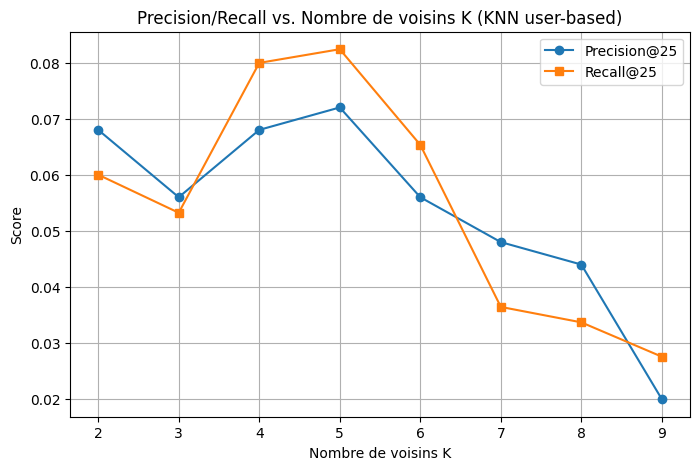

In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, desc

# Paramètres
k_range = range(2, 10)      # Par exemple : test K de 2 à 20 voisins
N_RECO = 25                    # Nombre de recos à évaluer (top@N)
N_USERS = 10               # Nombre d'utilisateurs testés (adapte selon temps/calcul)

# Embeddings users
user_matrix = np.stack(user_factors["features"].values)
user_ids = user_factors["userId"].values

precision_scores = []
recall_scores = []

for k in k_range:
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn.fit(user_matrix)

    precision_list = []
    recall_list = []
    # Boucle sur N_USERS du test
    for user in test_users[:N_USERS]:
        if user not in user_ids:
            continue
        idx = np.where(user_ids == user)[0][0]
        _, neighbor_idxs = knn.kneighbors([user_matrix[idx]], n_neighbors=k+1)
        neighbor_ids = user_ids[neighbor_idxs[0][1:]]  # On enlève lui-même

        # Films déjà vus (train)
        seen_train = train.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
        # Films vus par voisins (train)
        neighbors_movies = train.filter(col("userId").isin(list(neighbor_ids)))
        recos = (
            neighbors_movies
            .filter(~col("movieId").isin(seen_train))
            .groupBy("movieId")
            .agg(avg("rating").alias("mean_rating"))
            .orderBy(desc("mean_rating"))
            .limit(N_RECO)
        )
        reco_movies = recos.select("movieId").rdd.flatMap(lambda x: x).collect()
        # Films réellement vus (test)
        seen_test = test.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
        if len(seen_test) == 0:
            continue

        hits = set(reco_movies) & set(seen_test)
        precision = len(hits) / N_RECO
        recall = len(hits) / len(seen_test)
        precision_list.append(precision)
        recall_list.append(recall)

    precision_scores.append(np.mean(precision_list) if precision_list else 0)
    recall_scores.append(np.mean(recall_list) if recall_list else 0)
    print(f"K={k} -- Precision@{N_RECO}: {precision_scores[-1]:.4f} -- Recall@{N_RECO}: {recall_scores[-1]:.4f}")

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(list(k_range), precision_scores, label=f'Precision@{N_RECO}', marker='o')
plt.plot(list(k_range), recall_scores, label=f'Recall@{N_RECO}', marker='s')
plt.title('Precision/Recall vs. Nombre de voisins K (KNN user-based)')
plt.xlabel('Nombre de voisins K')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
target_user_id = 12  # À remplacer par le userId que tu veux
# Cherche l’index du user dans la matrice
idx = np.where(user_ids == target_user_id)[0][0]

# Trouver les plus proches voisins (similaires)
_, neighbor_indices = knn.kneighbors([user_matrix[idx]], n_neighbors=6)
neighbor_user_ids = user_ids[neighbor_indices[0][1:]]  # on enlève le user lui-même

print("Utilisateurs les plus similaires à", target_user_id, ":", neighbor_user_ids)


Utilisateurs les plus similaires à 12 : [ 36283 187847 148573  11003 116835]


In [24]:
from pyspark.sql.functions import col, avg, desc

# Les films déjà vus par le user
seen_movies = ratings.filter(col("userId") == target_user_id).select("movieId").rdd.flatMap(lambda x: x).collect()

# Notes de ses voisins
neighbor_ratings = ratings.filter(col("userId").isin(list(neighbor_user_ids)))

# Films bien notés par les voisins, mais pas vus par le user
recos = (
    neighbor_ratings
    .filter(~col("movieId").isin(seen_movies))
    .groupBy("movieId")
    .agg(avg("rating").alias("mean_rating"))
    .orderBy(desc("mean_rating"))
    .limit(10)
)

# Jointure avec les titres
recos_with_titles = recos.join(movies, on="movieId", how="left")
recos_with_titles.select("movieId", "title", "mean_rating").show(truncate=False)


+-------+-------------------------------------+-----------+
|movieId|title                                |mean_rating|
+-------+-------------------------------------+-----------+
|47099  |Pursuit of Happyness, The (2006)     |5.0        |
|2125   |Ever After: A Cinderella Story (1998)|5.0        |
|77414  |Last Song, The (2010)                |5.0        |
|2671   |Notting Hill (1999)                  |5.0        |
|192385 |A Star Is Born (2018)                |5.0        |
|457    |Fugitive, The (1993)                 |5.0        |
|5066   |Walk to Remember, A (2002)           |5.0        |
|4310   |Pearl Harbor (2001)                  |5.0        |
|6323   |Identity (2003)                      |5.0        |
|80222  |Step Up 3D (2010)                    |5.0        |
+-------+-------------------------------------+-----------+



### METRIC

In [38]:
precision_list, recall_list = [], []
k = 25

# Supposons que test_users est la liste de userId à tester (par ex : ratings_test.select("userId").distinct().rdd.flatMap(lambda x: x).collect())
for user in test_users[:100]:
    # Assure que user est bien un int Python natif
    user = int(user)

    # Films déjà vus dans le train
    seen_train = train.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    # Films réellement vus dans le test
    seen_test = test.filter(col("userId") == user).select("movieId").rdd.flatMap(lambda x: x).collect()
    if len(seen_test) == 0:
        continue

    # Recommandations ALS pour ce user (predict top k)
    user_df = spark.createDataFrame([[user]], ["userId"])
    recos = recos.recommendForUserSubset(user_df, k)
    reco_movies = recos.selectExpr("explode(recommendations) as rec") \
                       .select("rec.movieId") \
                       .rdd.flatMap(lambda x: x).collect()
    # (Optionnel: retirer les films déjà vus dans le train si tu veux)
    reco_movies = [m for m in reco_movies if m not in seen_train]

    hits = set(reco_movies) & set(seen_test)
    precision = len(hits) / k
    recall = len(hits) / len(seen_test)
    precision_list.append(precision)
    recall_list.append(recall)

print(f"ALS Precision@{k} : {np.mean(precision_list):.3f}")
print(f"ALS Recall@{k}    : {np.mean(recall_list):.3f}")


PySparkAttributeError: [ATTRIBUTE_NOT_SUPPORTED] Attribute `recommendForUserSubset` is not supported.